In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [5]:
# import ee
# ee.Authenticate()
# ee.Initialize()
# print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

## Green space score

In [78]:
# Filtering green pixels
imgs_raw=[]
imgs_mask = []
imgs_green = []
ratios = []
for f in os.listdir("imgs//"):
    print(f)
    if f[-4:] == ".png":
        img = cv2.imread('imgs//{}'.format(f))
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        height, width = img.shape[:2]

        # Create a black circle mask with same dimensions as image
        mask = np.zeros((height, width), np.uint8)
        cv2.circle(mask, (width//2, height//2), min(height, width)//2, (255, 255, 255), -1)
        img = cv2.bitwise_and(img, img, mask=mask)
        # img[:, :, 3] = mask1[:,:,0]
        # plt.imshow(masked_img)
        imgs_raw.append(img)
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv_img,(36, 25, 25), (70, 255,255))
        
        result = cv2.bitwise_and(img, img, mask=mask)
        # print(result)
        # find number of black pixels
        # mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        
        radius = min(height, width) // 2

        # Calculate area of circle
        area = np.pi * (radius ** 2)
        white_pix = cv2.countNonZero(mask)
    

        # find total number of pixels
        tot_pix = mask.size
   
        # calculate black pixel ratio        
        ratio = white_pix/area
        
        imgs_mask.append(mask)
        imgs_green.append(result)
        ratios.append(ratio)
        

feature_pipeline.svg
sample1.png
sample2.png
sample3.png
sample4.png
4


0
0
0
1


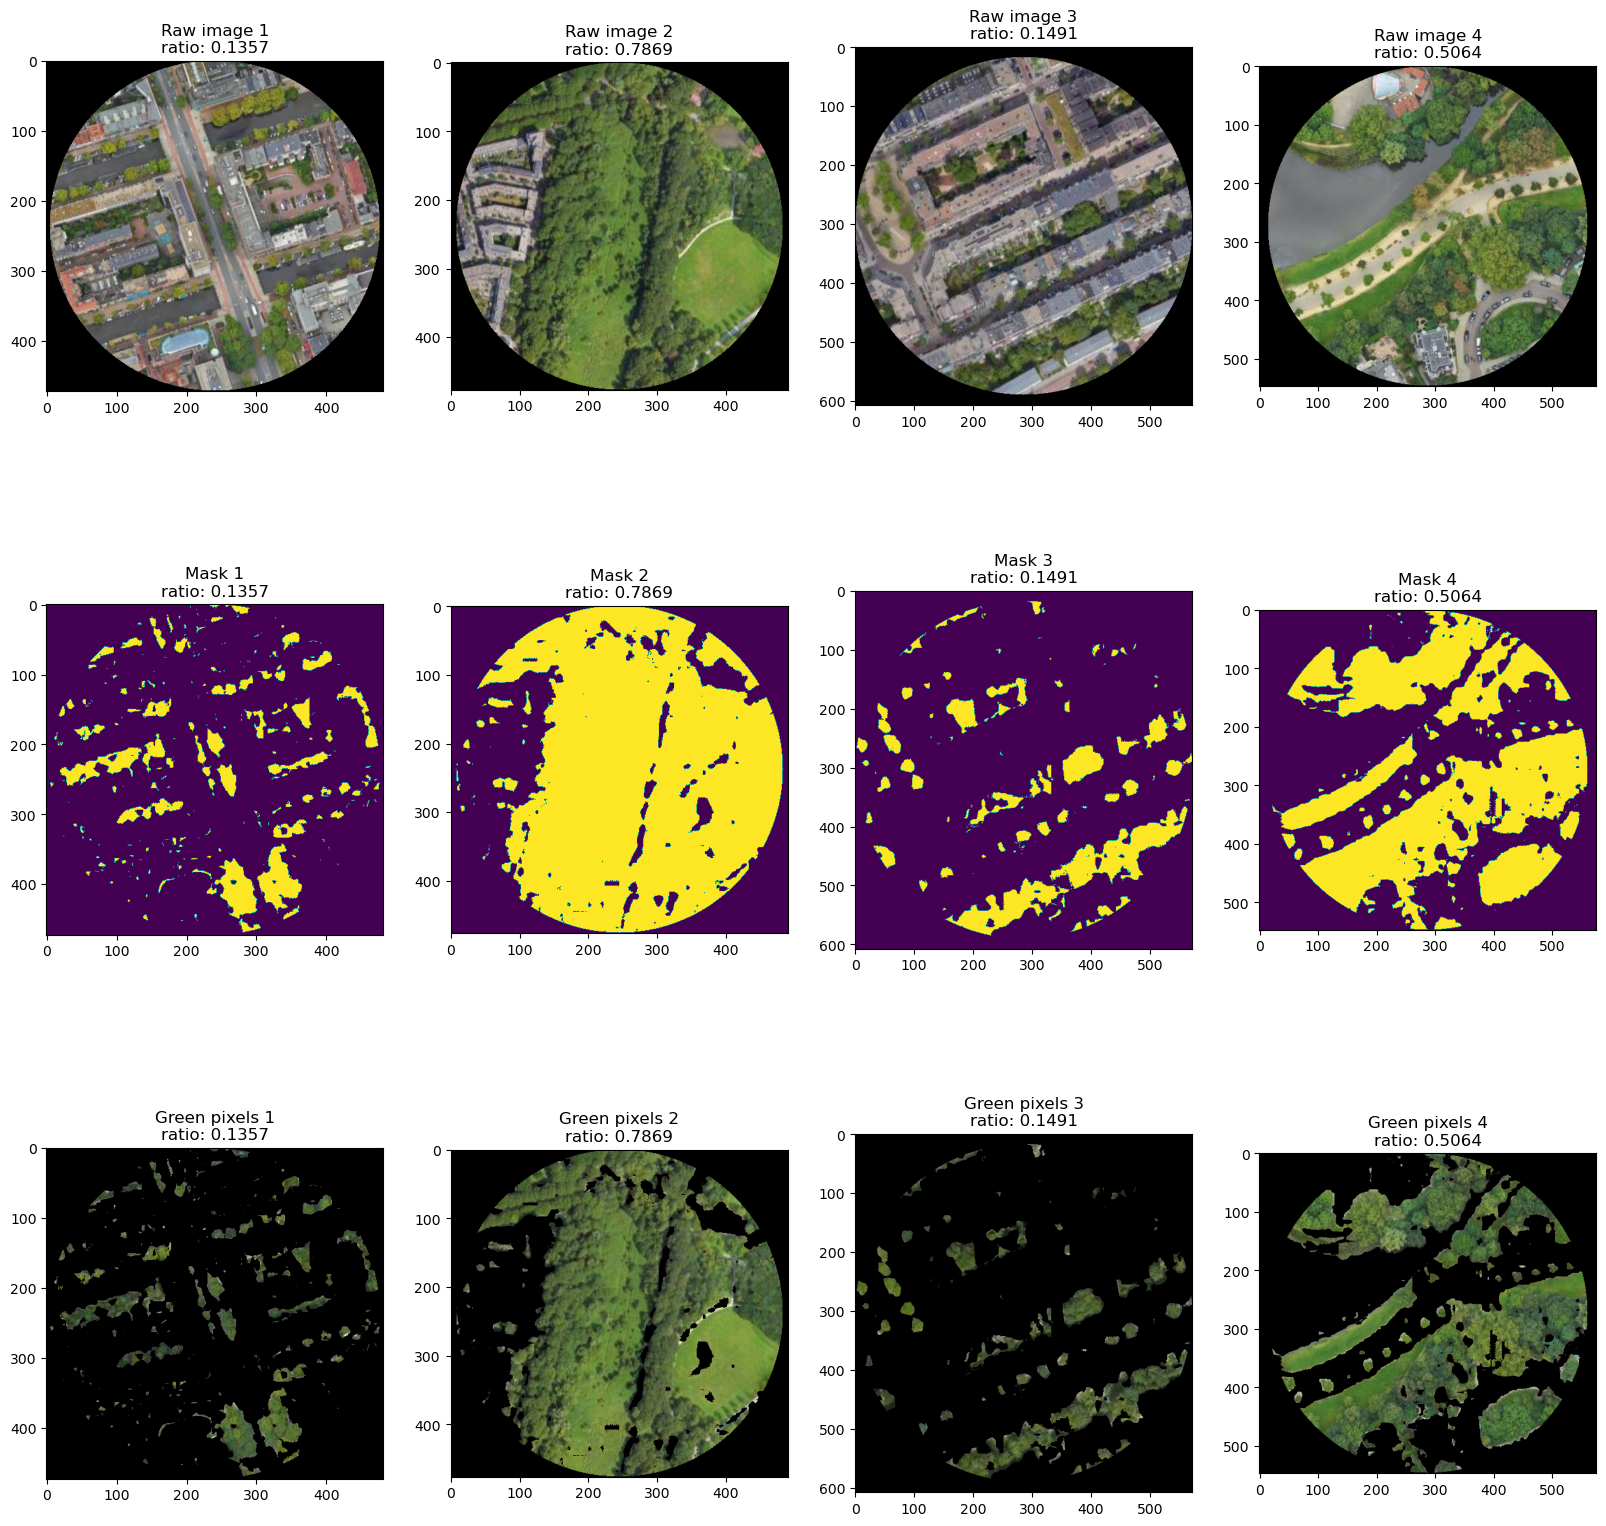

In [81]:
fig,ax = plt.subplots(3,4,figsize=(20,20))
for i in range(0,len(imgs_raw)):
    # print(i//3)
    ax[i//4,i%4].imshow(imgs_raw[i])
    ax[i//4,i%4].set_title("Raw image {}\nratio: {}".format(i+1,round(ratios[i],4)))
    
    ax[i//4+1,i%4].imshow(imgs_mask[i])
    
    ax[i//4+1,i%4].set_title("Mask {}\nratio: {}".format(i+1,round(ratios[i],4)))
    
    ax[i//4+2,i%4].imshow(imgs_green[i])
    ax[i//4+2,i%4].set_title("Green pixels {}\nratio: {}".format(i+1,round(ratios[i],4)))
    
    


### From address to Green Space Score

In [2]:
import pandas as pd
df = pd.read_csv("funda_sample_ams.csv",index_col=0)

<!-- 4/1AVHEtk7YD8w79MQPOw_FxpfR5jFAJ_RKKm1uSGOkfYjL1TxciveBfZa97mw -->

In [1]:
# Import the earth-engine module
import ee
# ee.Authenticate()
# ee.Initialize()

In [5]:
import requests
import json
import urllib

In [22]:
# https://developers.google.com/maps/documentation/geocoding/intro
base_url= "https://maps.googleapis.com/maps/api/geocode/json?"
AUTH_KEY = ""

In [17]:
def get_location(address):
    parameters = {"address": "{}, Amsterdam, Netherlands".format(address),
             "key": AUTH_KEY}
    print(f"{base_url}{urllib.parse.urlencode(parameters)}")
    r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")
    data = json.loads(r.content)
    return data["results"][0]["geometry"]["location"]["lat"], data["results"][0]["geometry"]["location"]["lng"],data["results"][0]["geometry"]["location_type"]

In [25]:
for index, row in df.iterrows():
    lat, lng, loc_type = get_location(str(row["zip"]) + ", "+row["address"])
    df.loc[index,"lat"] = lat
    df.loc[index,"lng"] = lng
    df.loc[index,"loc_type"] = loc_type
    print(f"{index} {lat} {lng} {loc_type}")

In [32]:
print(df["lat"].sort_values(ascending=True).head(10)[:3])

358    52.19891
57     52.19891
120    52.19891
Name: lat, dtype: float64


In [39]:
# remove by index
df = df.drop(df[df["lat"] < 52.2].index)
df = df.drop(df[df["price"] > 1000000].index)

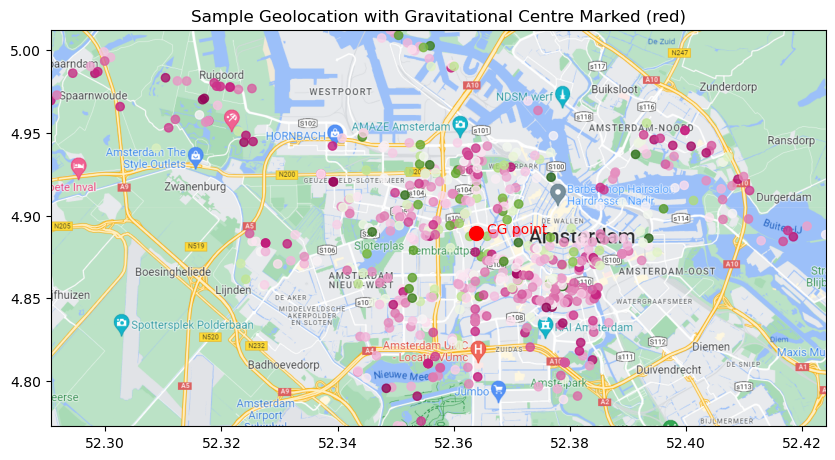

In [102]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
img = plt.imread("imgs/figures/ams_map.png")
center = sum(df["lat"])/len(df["lat"]), sum(df["lng"])/len(df["lng"])
ext = [min(df["lat"]), max(df["lat"]), min(df["lng"]), max(df["lng"])]
ax.scatter(df["lat"],df["lng"],alpha=0.8, c=df["price"],cmap="PiYG",zorder=1)
ax.scatter(center[0],center[1],c="red",zorder=2,s=100)
ax.annotate("CG point",
            xy=center, xycoords='data',
            xytext=(center[0]+0.002,center[1]+0.0001) ,color="red",
            )
ax.imshow(img, zorder=0, extent=ext, aspect='auto')
aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)
ax.set_title("Sample Geolocation with Gravitational Centre Marked (red)")
plt.show()

In [21]:
# urllib.parse.urlencode turns parameters into url
# df.to_csv("funda_sample_ams_geocoded.csv")

In [64]:
print(min(df["lat"]))
print(max(df["lat"]))
print(min(df["lng"]))
print(max(df["lng"]))

52.290589
52.4240881
4.7727163
5.012233999999999
